# Neural Style Transfer

In [1]:
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imageio import imread, imsave
%matplotlib inline

## Setting Configuration

In [2]:
IMAGE_WIDTH = 400
IMAGE_HEIGHT = 300
COLOR_CHANNELS = 3
NOISE_RATIO = 0.6
MEANS = np.array([123.68, 116.779, 103.939]).reshape((1, 1, 1, 3)) 
VGG_MODEL = 'Models/imagenet-vgg-verydeep-19.mat'
STYLE_IMAGE = 'Data/style.jpg'
CONTENT_IMAGE = 'Data/content.jpg'
GENERATED_IMAGE = 'Data/generated.jpg'

## Model Loading

In [3]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [4]:
model = load_vgg_model(VGG_MODEL)
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

## Data Loading

In [5]:
def generate_noise_image(content_image, noise_ratio=NOISE_RATIO):
    noise_image = np.random.uniform(-20, 20, (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

In [6]:
def reshape_and_normalize_image(image):
    image = np.reshape(image, ((1,) + image.shape))
    image = image - MEANS
    return image

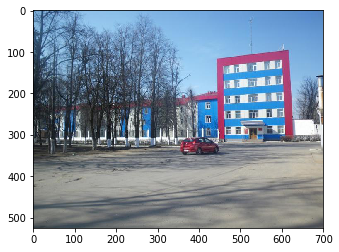

In [7]:
content_image = imread(CONTENT_IMAGE)
IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS = content_image.shape
plt.imshow(content_image);

In [8]:
content_image.shape

(525, 700, 3)

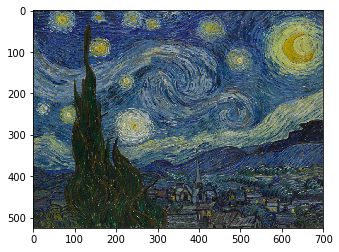

In [9]:
style_image = imread(STYLE_IMAGE)
plt.imshow(style_image);

In [10]:
style_image.shape

(525, 700, 3)

In [11]:
content_image = reshape_and_normalize_image(content_image)
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


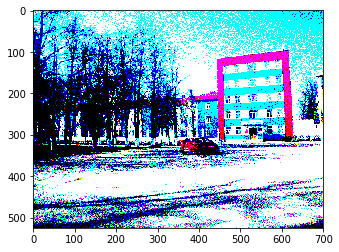

In [12]:
generated_image = generate_noise_image(content_image)
plt.imshow(generated_image[0]);

## Computing Content Cost

In [13]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [-1]))
    J_content = tf.reduce_sum((a_C_unrolled - a_G_unrolled)**2) / (4 * n_H * n_W * n_C)
    return J_content

## Computing Style Cost

In [14]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [15]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    J_style_layer = tf.reduce_sum((GS - GG)**2) / (4 * (n_H * n_W)**2 * n_C**2)
    return J_style_layer

In [16]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [17]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer
    return J_style

## Computing Total Cost

In [18]:
def total_cost(J_content, J_style, alpha=10, beta=40):
    J = alpha * J_content + beta * J_style
    return J

## Training Model

In [19]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [20]:
model = load_vgg_model(VGG_MODEL)

In [21]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)

In [22]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

In [23]:
J = total_cost(J_content, J_style, alpha=10, beta=40)

In [24]:
optimizer = tf.train.AdamOptimizer(2)
train_step = optimizer.minimize(J)

In [25]:
def save_image(path, image):
    image = image + MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    imsave(path, image)

In [26]:
temp_images = []

def model_nn(sess, input_image, num_iterations=200):
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(model['input'].assign(input_image))
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])
        if i % 20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + ":")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            temp_images.append(generated_image)
    save_image(GENERATED_IMAGE, generated_image)          
    return generated_image

In [27]:
model_nn(sess, generated_image)

Iteration 0:
total cost = 2981553400.0
content cost = 7386.5938
style cost = 74536984.0
Iteration 20:
total cost = 310500580.0
content cost = 13314.526
style cost = 7759185.5
Iteration 40:
total cost = 117973704.0
content cost = 14479.548
style cost = 2945722.8
Iteration 60:
total cost = 65791748.0
content cost = 14945.947
style cost = 1641057.2
Iteration 80:
total cost = 46169270.0
content cost = 15218.452
style cost = 1150427.2
Iteration 100:
total cost = 36049820.0
content cost = 15412.541
style cost = 897392.44
Iteration 120:
total cost = 29797600.0
content cost = 15575.859
style cost = 741046.06
Iteration 140:
total cost = 25441292.0
content cost = 15719.677
style cost = 632102.4
Iteration 160:
total cost = 22194694.0
content cost = 15848.989
style cost = 550905.1
Iteration 180:
total cost = 19663236.0
content cost = 15969.13
style cost = 487588.6


array([[[[   9.064272 ,   46.480602 ,   76.702126 ],
         [ -16.628645 ,   15.425656 ,   78.506195 ],
         [ -76.18737  ,  -30.233559 ,  103.34031  ],
         ...,
         [  30.038927 ,   56.349052 ,   82.861176 ],
         [   9.394719 ,   56.94834  ,   40.39027  ],
         [  33.671787 ,   88.17842  ,   35.865852 ]],

        [[ -62.380966 ,  -11.262358 ,   60.783737 ],
         [ -70.92014  ,  -40.3353   ,    8.663395 ],
         [ -70.102005 ,  -38.607513 ,    1.1759648],
         ...,
         [  23.837637 ,   54.755684 ,   70.30686  ],
         [  -2.5383513,   29.631876 ,   37.283558 ],
         [  24.420456 ,   44.936844 ,   56.002342 ]],

        [[  18.047865 ,   40.025394 ,   80.42778  ],
         [ -55.296844 ,  -52.43165  ,   75.10685  ],
         [ -44.667553 ,  -33.977577 ,   29.53153  ],
         ...,
         [ -31.101622 ,    3.030628 ,   77.93508  ],
         [ -25.273376 ,   11.144641 ,   59.09032  ],
         [   7.1815987,   33.148857 ,   81.55188  ]],

## Showing Result

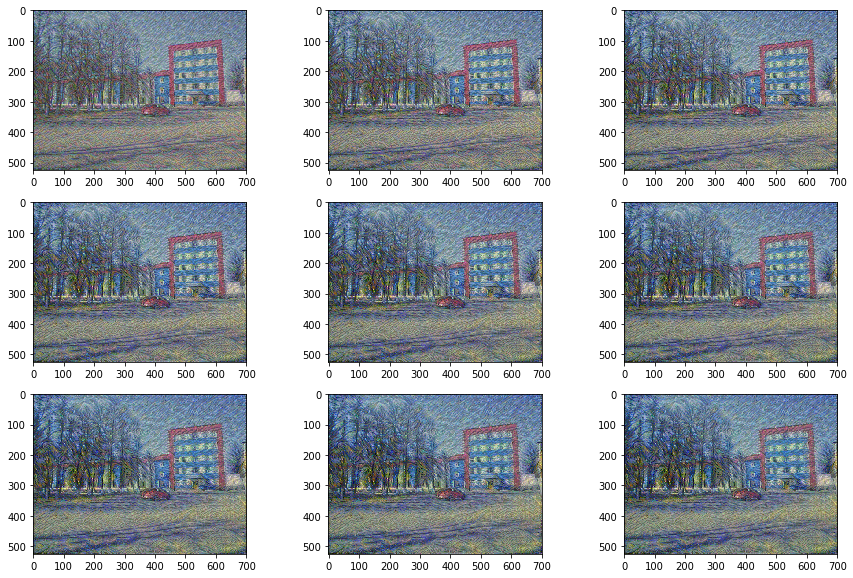

In [33]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for i, temp_image in enumerate(temp_images[1:]):
    temp_image = temp_image + MEANS
    temp_image = np.clip(temp_image[0], 0, 255).astype('uint8')    
    ax[i // 3][i % 3].imshow(temp_image);

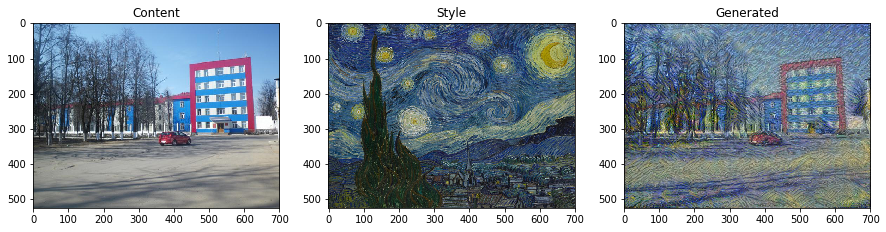

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(imread(CONTENT_IMAGE));
ax[0].set_title("Content");
ax[1].imshow(imread(STYLE_IMAGE));
ax[1].set_title("Style");
ax[2].imshow(imread(GENERATED_IMAGE));
ax[2].set_title("Generated");